### Задание: Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [3]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [50]:
sales_of_company_x = pd.read_csv('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Временные ряды/Лекция_1/Series/monthly-sales-of-company-x-jan-6.csv').dropna().values[:, 1]

In [51]:
sales_of_company_x.shape

(77,)

Text(0.5, 1.0, 'Monthly sales of company X')

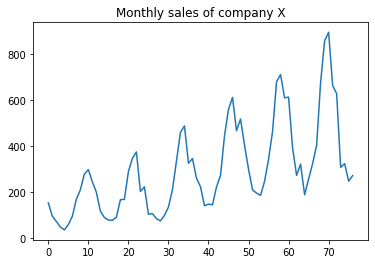

In [52]:
# Посмотрим на наши данные
plt.plot(sales_of_company_x)
plt.title('Monthly sales of company X')

In [53]:
# Проверим данные на стационарность
test_stationarity(sales_of_company_x)

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


Видим, что p-value больше 0,05, что значит, что наш ряд нестационарный.

### 1) Вначале применим модель ARIMA

In [54]:
best_aic = np.inf 
best_order = None
best_mdl = None

for p in range(12):
    for d in range(12):
        for q in range(12):
            try:
                tmp_mdl = smt.ARIMA(sales_of_company_x, order=(p,d,q)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 839.04105 | order: (11, 2, 0)


In [55]:
best_mdl

Results of Dickey-Fuller Test:
Test Statistic                 -5.418873
p-value                         0.000003
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


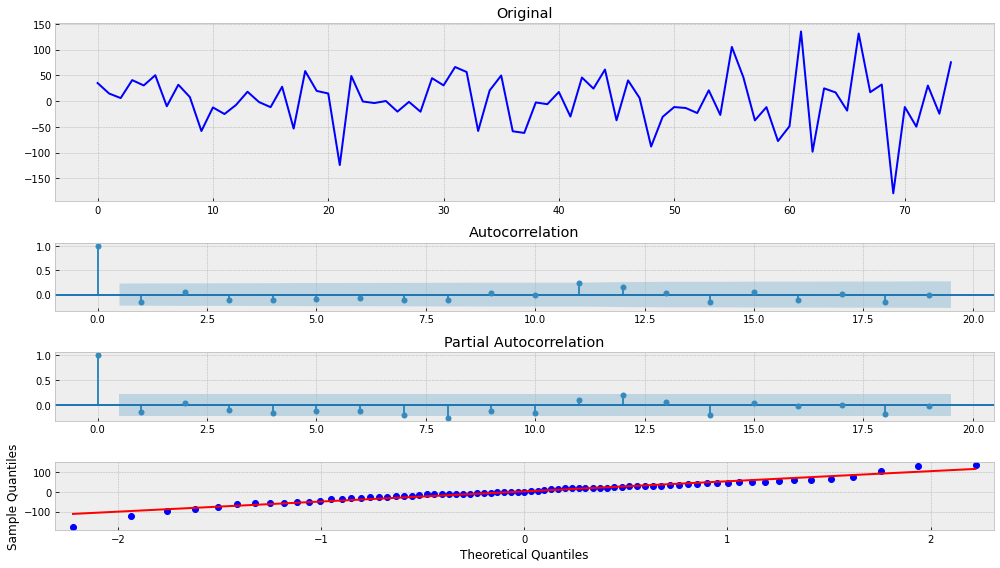

In [56]:
# Посмотрим на остатки после применения модели
tsplot(best_mdl.resid)

### 2) Теперь применим модель GARCH

In [116]:
# Применим несколько преобразований
series = sales_of_company_x.copy()
series = series.astype(float)
series = series[12:] - series[:-12]
series = series[11:] - series[:-11]
series = series[1:] - series[:-1]

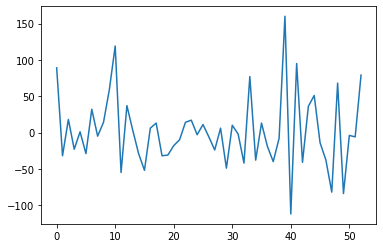

In [117]:
plt.plot(series)

In [118]:
# Изпользуем параметры, полученные после обучения модели ARIMA
p_ = 11
o_ = 2
q_ = 0

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -276.809
Distribution:      Standardized Student's t   AIC:                           585.618
Method:                  Maximum Likelihood   BIC:                           617.142
                                              No. Observations:                   53
Date:                      Wed, Aug 24 2022   Df Residuals:                       52
Time:                              22:17:53   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2

Results of Dickey-Fuller Test:
Test Statistic                -1.092722e+01
p-value                        1.003085e-19
#Lags Used                     0.000000e+00
Number of Observations Used    5.200000e+01
Critical Value (1%)           -3.562879e+00
Critical Value (5%)           -2.918973e+00
Critical Value (10%)          -2.597393e+00
dtype: float64


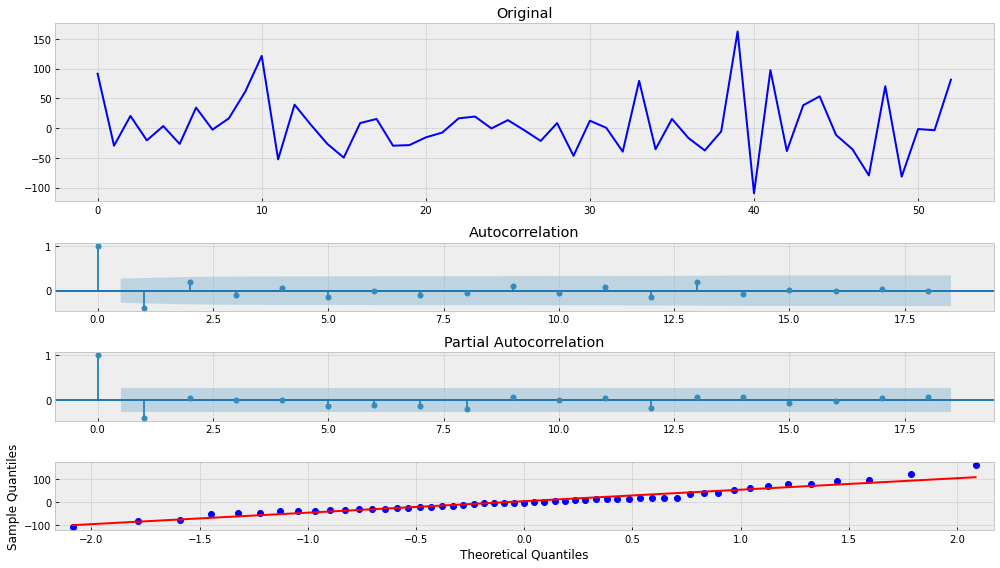

In [119]:
tsplot(res.resid)